# Задача: подключиться к апи и собрать что угодно

Так как стартап связан с детьми и подростками, я решила посмотреть, какую информацию я смогу достать по кейворду Гарри Поттер в категории игрушек.:) 
В качестве страны я выбрала Великобританию, так как это родина Гарри Поттера, интересовали только объявления из самой Великобритании, отбирала новейшие.

Я использовала **Finding API**, и смогла вытащить следующее:

- itemId - айдишник товара
- title - название товара
- viewItemURL - ссылка на товар
- location - локация магазина(страна и город)
- currentPrice - цена
- topRatedListing - является ли объявление топовым
- primaryCategory - название подкатегории

Несмотря на то, что, согласно документации, можно вытащить информацию о магазине и средний рейтинг продавца, сделать этого не удалось - регулярно выдаёт ошибку, что такого нет.

## EDA

Так как из числовых колонок есть только цена, я решила посмотреть средние, медианы и моды для трёх самых популярных категорий и четырёх самых популярных городов.

#### Вывод по категориям
- Самый дорогой и популярный товар - лего комплекты, среднее, мода и медиана значительно выше, чем у двух других категорий.
- Самые низкие цены принадлежат категории с лего фигурками.
- Медианы и моды во всех трёх категориях близки друг к другу. Из-за большого количества выбросов средние далеки от них. Самый большой выброс есть в категории фигурок - судя по всему, нашлась очень интересная коллекционная фигурка!

#### Вывод по городам
- Самые высокие значения по средней, моде и самому кол-ву товаров в Лондоне. Самые высокие значения медиан в неуказанных городах(UK)
- Для всех городов моды и средние приблизительно равны, кроме UK, что легко объяснимо: эта категория включает в себя разные города
- В Лондоне больше всего значений-выбросов
- В городе Данстэбл самые низкие цены, медиана, мода и среднее не сильно различаются.

## Небольшой искусственный эксперимент

Так как мне всё-таки хотелось что-то посчитать, мой выбор пал на медиану цен для топ объявлений и не топ объявлений. Выбрала медианы, потому что средние слишком не информативны с таким количеством выбросов.

**Вывод по бутстрапу для медианы цен**

0 не входит в интервал, отклоняем H1, **стат значимых различий между топовыми и не топовыми объявлениями нет**

In [220]:
import pandas as pd 
import numpy as np

from scipy import stats as st
from scipy.stats import norm

import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

from tqdm.auto import tqdm


import seaborn as sns
import matplotlib.pyplot as plt

from ebaysdk.finding import Connection as Finding 
from ebaysdk.exception import ConnectionError 

In [276]:
#стили графиков
sns.set (
    font_scale =1.5,
    style = 'whitegrid',
    rc= {'figure.figsize': (30,7)}
)

## Подключение к API Finding, выгрузка данных

In [2]:
APPLICATION_ID = 'Kristina-testtest-PRD-49c673f76-f8f8c54d'

In [3]:
def get_results(payload):
    try:
        api = Finding(siteid='EBAY-GB', appid=APPLICATION_ID, config_file=None)
        response = api.execute('findItemsAdvanced', payload)
        return response.dict()
    except ConnectionError as e:
        print(e)
        print(e.response.dict())

Задаю критерии выгрузки:
В качестве страны я выбрала Великобританию, так как это родина Гарри Поттера, интересовали только объявления из самой Великобритании, отбирала новейшие.

In [4]:
payload = {
        'keywords': 'Harry Potter', 
        'categoryId': ['220'],
        'itemFilter': [
            {'name': 'LocatedIn', 'value': 'GB'},
        ],
        'sortOrder': 'StartTimeNewest'
}

results = get_results(payload)

Задаю функцию для подсчёта страниц - это нужно, так как один реквест ограничен сотней товаров, а я хочу выгрузить не только одну страничку.

In [5]:
def get_total_pages(results):
    if results:
        return int(results.get('paginationOutput').get('totalPages'))
    else:
        return

In [6]:
def search_ebay(payload):
    
    results = get_results(payload)
    total_pages = get_total_pages(results)
    
    items_list = []      
    i = 2
    while(i <= total_pages and i <=100 ): # 100 - лимит выгрузки страниц
        payload['paginationInput'] = {'entriesPerPage': 100, 'pageNumber': i}        
        results = get_results(payload)
        items_list.extend(results['searchResult']['item'])
        i += 1
      

    products_list = []
    
    for item in items_list:
        
        row = {
            'itemId': item.get('itemId'),
            'title': item.get('title'),
            'viewItemURL': item.get('viewItemURL'),
            'location': item.get('location'),
            'currentPrice': item.get('sellingStatus').get('currentPrice').get('value'),
            'topRatedListing': item.get('topRatedListing'),
            'primaryCategory': item.get('primaryCategory').get('categoryName'),
        }

        products_list.append(row)
        
    df = pd.DataFrame(products_list)
    return df

In [7]:
df = search_ebay(payload)

In [14]:
df.head(3)

,itemId,title,viewItemURL,location,currentPrice,topRatedListing,primaryCategory
0,195563178472,"LEGO Harry Potter - 75967 , 75965 both complet...",https://www.ebay.co.uk/itm/LEGO-Harry-Potter-7...,"Weymouth,United Kingdom",15.0,false,LEGO (R) Complete Sets & Packs
1,404114434259,Funko POP! Movies Harry Potter Draco Malfoy #1...,https://www.ebay.co.uk/itm/Funko-POP-Movies-Ha...,"Cheltenham,United Kingdom",16.0,true,Action Figures
2,225361651940,SUPERB MATTEL HARRY POTTER GOBLET OF FIRE SCEN...,https://www.ebay.co.uk/itm/SUPERB-MATTEL-HARRY...,"Rhyl,United Kingdom",4.99,false,Modern Manufacture


Отлично, дф собрался! Теперь можно смотреть, в каком он состоянии.

## EDA: проверка и подготовка дф, распределение цен по категориям городам

### Проверка и подготовка дф

In [277]:
def get_info(df): #функция для получения shape, types и количества NAN в колонках
    shape = df.shape
    types = df.dtypes
    isna_sum = df.isna().sum()
    dict = {"shape": shape, "types":types, "NAN" : isna_sum}
    return dict

In [278]:
get_info(df)

{'shape': (9900, 7),
 'types': itemId              object
 title               object
 viewItemURL         object
 location            object
 currentPrice       float64
 topRatedListing     object
 primaryCategory     object
 dtype: object,
 'NAN': itemId             0
 title              0
 viewItemURL        0
 location           0
 currentPrice       0
 topRatedListing    0
 primaryCategory    0
 dtype: int64}

In [279]:
df.currentPrice = df.currentPrice.astype('float')

Достаю города из колонки с локацией:

In [280]:
df.location = df.location.apply(lambda x: str(x).split(',')[0])

In [281]:
df.head(3)

,itemId,title,viewItemURL,location,currentPrice,topRatedListing,primaryCategory
0,195563178472,"LEGO Harry Potter - 75967 , 75965 both complet...",https://www.ebay.co.uk/itm/LEGO-Harry-Potter-7...,Weymouth,15.00,false,LEGO (R) Complete Sets & Packs
1,404114434259,Funko POP! Movies Harry Potter Draco Malfoy #1...,https://www.ebay.co.uk/itm/Funko-POP-Movies-Ha...,Cheltenham,16.00,true,Action Figures
2,225361651940,SUPERB MATTEL HARRY POTTER GOBLET OF FIRE SCEN...,https://www.ebay.co.uk/itm/SUPERB-MATTEL-HARRY...,Rhyl,4.99,false,Modern Manufacture


Общие распределения: цены, города, категории

Что с распределением цен?

In [282]:
df.currentPrice.describe()

count    9900.000000
mean       29.787906
std        58.467886
min         0.010000
25%         5.000000
50%        12.000000
75%        30.000000
max      2000.000000
Name: currentPrice, dtype: float64

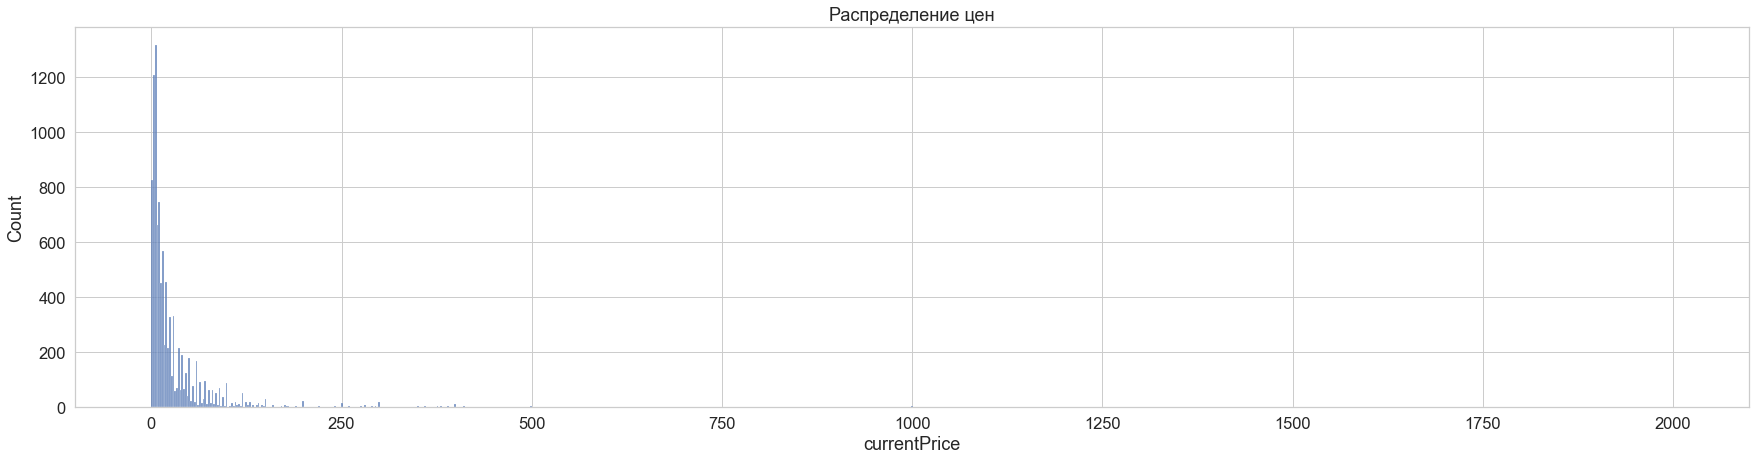

In [283]:
sns.histplot(df.currentPrice)
plt.title('Распределение цен');

Классическая картина для цен: много небольших значений, выбросы, растянутый правый хвост.

Какие есть категории, сколько в них товаров?

In [284]:
print('Общее кол-во: ', df.primaryCategory.nunique())

Общее кол-во:  60


In [285]:
df.primaryCategory.value_counts().head(10)

LEGO (R) Complete Sets & Packs               3245
LEGO (R) Minifigures                         1934
Action Figures                               1416
Modern Manufacture                            845
LEGO (R) Bricks, Pieces & Parts               573
Jigsaws                                       564
Card Games-Contemporary                       317
Branded Soft Toys                             161
Construction Toy Pieces & Parts               138
LEGO (R) Instruction Manuals & Catalogues     107
Name: primaryCategory, dtype: int64

Сколько составляют 3 первых категории от общего числа товаров ?

In [286]:
(df.primaryCategory.value_counts().head(3).sum() / df.primaryCategory.count()).round(2)

0.67

Уже видно трёх лидеров, к ним вернёмся позже!

То же самое для городов:

In [287]:
print('Общее кол-во: ', df.location.nunique())

Общее кол-во:  883


In [288]:
df.location.value_counts().head(10)

London            463
United Kingdom    285
Dunstable         216
Manchester        212
Bristol           166
Glasgow           162
Ipswich           147
Aberdeen          120
Birmingham        115
Leicester         114
Name: location, dtype: int64

Как видим, некоторые продавцы не указали город, для них локация просто UK. 

### Категории и цены

Тут я посмотрю три самых популярных категории и распределение их цен.

In [289]:
df.primaryCategory.value_counts().head(10)

LEGO (R) Complete Sets & Packs               3245
LEGO (R) Minifigures                         1934
Action Figures                               1416
Modern Manufacture                            845
LEGO (R) Bricks, Pieces & Parts               573
Jigsaws                                       564
Card Games-Contemporary                       317
Branded Soft Toys                             161
Construction Toy Pieces & Parts               138
LEGO (R) Instruction Manuals & Catalogues     107
Name: primaryCategory, dtype: int64

In [290]:
list_top3_cat = df.primaryCategory.value_counts().head(3).index[:3].to_list()

In [291]:
list_top3_cat 

['LEGO (R) Complete Sets & Packs', 'LEGO (R) Minifigures', 'Action Figures']

Отбираю записи с этими категориями, смотрю значения средних, медиан и общее кол-во товаров в категории

In [292]:
df_top3_cat = df.query('primaryCategory in @list_top3_cat')

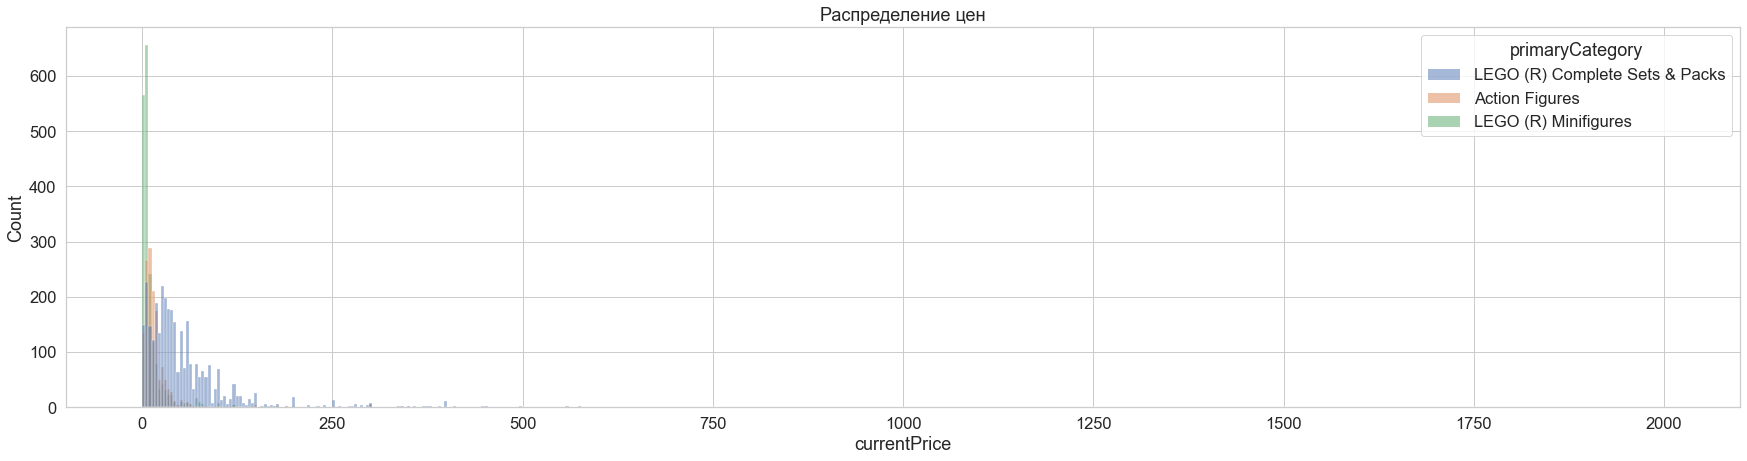

In [293]:
sns.histplot(data = df_top3_cat , x = 'currentPrice', hue = 'primaryCategory')
plt.title('Распределение цен');

Так как такой график не очень информативный, воспользуюсь боксплотом

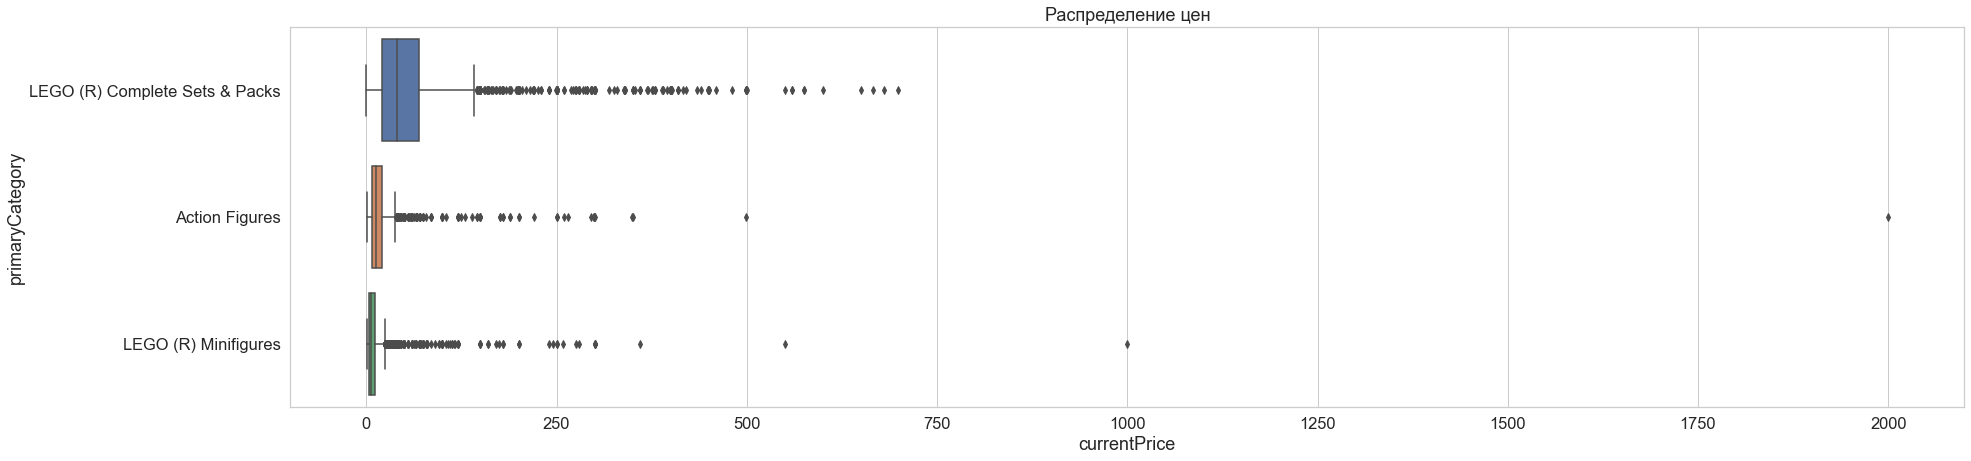

In [294]:
sns.boxplot(data = df_top3_cat , x = 'currentPrice', y = 'primaryCategory')
plt.title('Распределение цен');

In [295]:
axis_labels = ['category', 'mean', 'median', 'mode', 'count']
df_top3_price_stats = df_top3_cat.groupby('primaryCategory').agg({'currentPrice' : ['mean', 'median', pd.Series.mode, 'count']}) \
    .reset_index().droplevel(level = 0, axis = 1)  \
    .set_axis(axis_labels, axis = 1) 

In [296]:
df_top3_price_stats

,category,mean,median,mode,count
0,Action Figures,22.746886,12.99,10.00,1416
1,LEGO (R) Complete Sets & Packs,57.913763,39.95,35.00,3245
2,LEGO (R) Minifigures,15.206200,6.00,4.99,1934


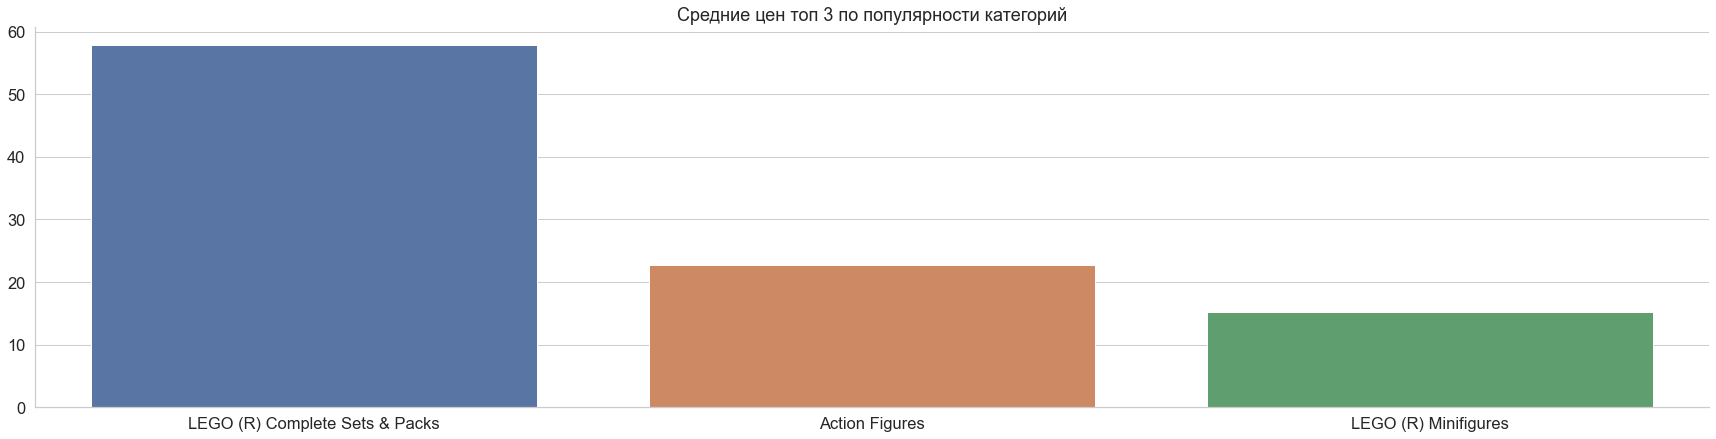

In [297]:
sns.barplot(data = df_top3_price_stats, x = 'category', y = 'mean', \
            order = df_top3_price_stats.sort_values('mean', ascending = False).category)
sns.despine()
plt.title('Средние цен топ 3 по популярности категорий')
plt.xlabel('')
plt.ylabel('')
plt.show()

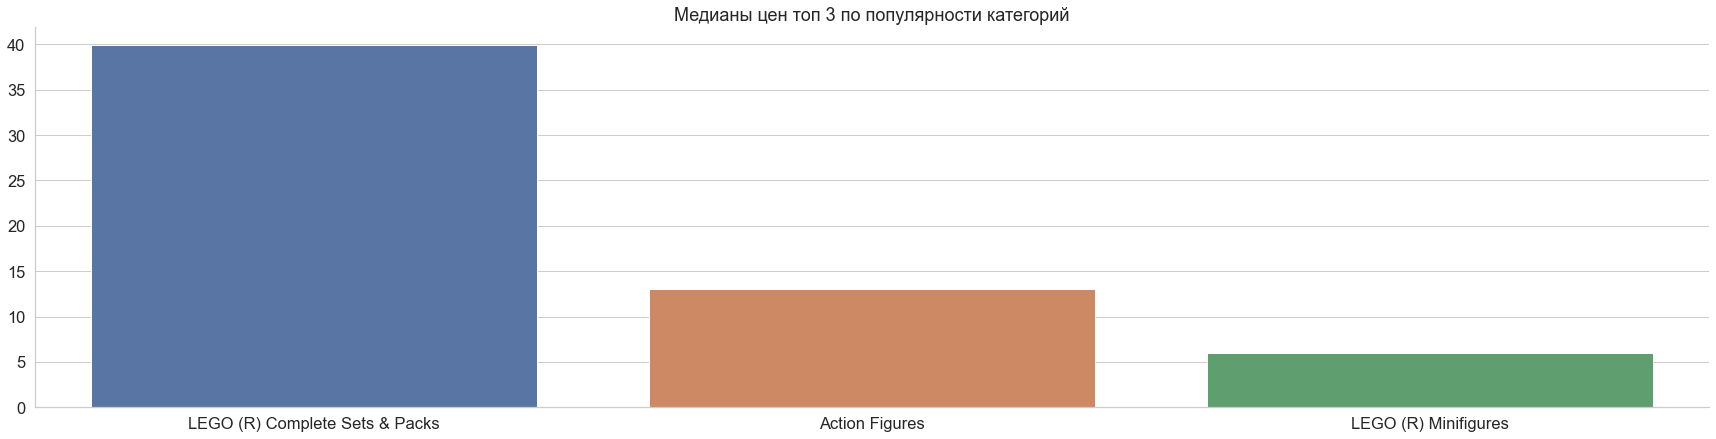

In [298]:
sns.barplot(data = df_top3_price_stats, x = 'category', y = 'median', \
            order = df_top3_price_stats.sort_values('median', ascending = False).category)
sns.despine()
plt.title('Медианы цен топ 3 по популярности категорий')
plt.xlabel('')
plt.ylabel('')
plt.show()

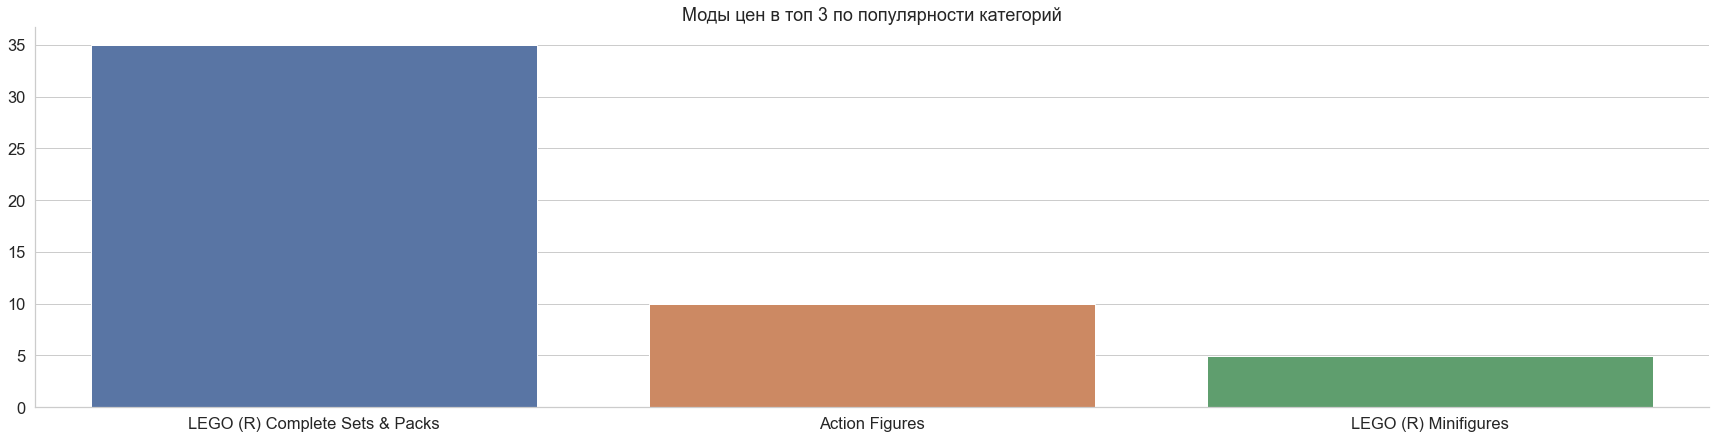

In [299]:
sns.barplot(data = df_top3_price_stats, x = 'category', y = 'mode', \
            order = df_top3_price_stats.sort_values('mode', ascending = False).category)
sns.despine()
plt.title('Моды цен в топ 3 по популярности категорий')
plt.xlabel('')
plt.ylabel('')
plt.show()

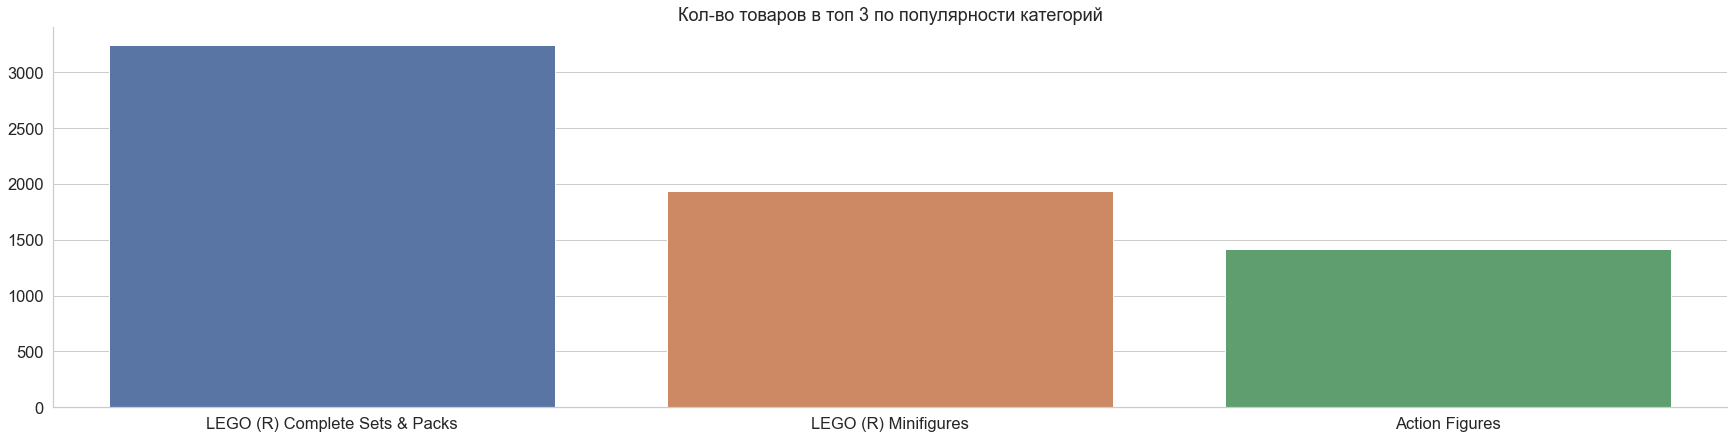

In [300]:
sns.barplot(data = df_top3_price_stats, x = 'category', y = 'count', \
            order = df_top3_price_stats.sort_values('count', ascending = False).category)
sns.despine()
plt.title('Кол-во товаров в топ 3 по популярности категорий')
plt.xlabel('')
plt.ylabel('')
plt.show()

#### Вывод по категориям
- Самый дорогой и популярный товар - лего комплекты, среднее, мода и медиана значительно выше, чем у двух других категорий.
- Самые низкие цены принадлежат категории с лего фигурками.
- Медианы и моды во всех трёх категориях близки друг к другу. Из-за большого количества выбросов средние далеки от них. Самый большой выброс есть в категории фигурок - судя по всему, нашлась очень интересная коллекционная фигурка!


### Города и цены

Городов достаточно много, при этом большая часть из них всего лишь с парой объявлений, что не очень интересно. Отберу 4 первых, так как их число кажется немного оторванным от остальных.

In [301]:
df.location.value_counts().head(10)

London            463
United Kingdom    285
Dunstable         216
Manchester        212
Bristol           166
Glasgow           162
Ipswich           147
Aberdeen          120
Birmingham        115
Leicester         114
Name: location, dtype: int64

In [302]:
list_top_city = df.location.value_counts().head().index[:4].to_list()

In [303]:
list_top_city 

['London', 'United Kingdom', 'Dunstable', 'Manchester']

Отбираю записи с этими категориями, смотрю значения средних, медиан, мод и общее кол-во товаров в категории. Моды в этом случае тоже важны, так как продавцы ставят цены, ориентируясь друг на друга.

In [304]:
df_top_city = df.query('location in @list_top_city')

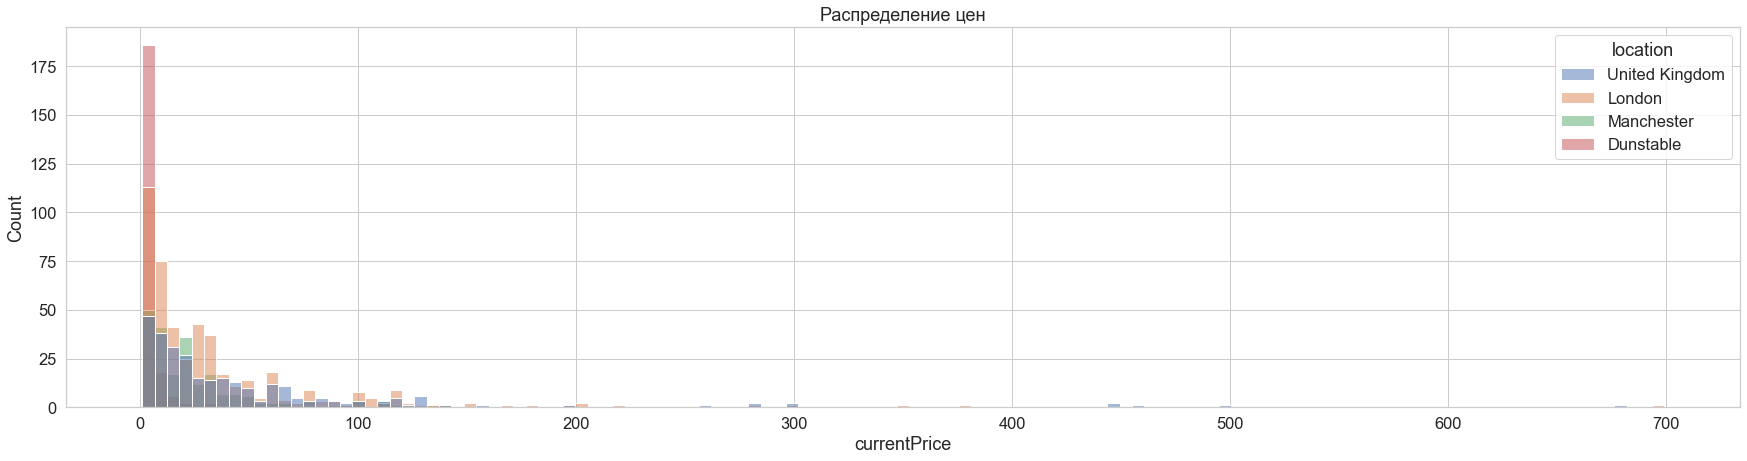

In [305]:
sns.histplot(data = df_top_city , x = 'currentPrice', hue = 'location')
plt.title('Распределение цен');

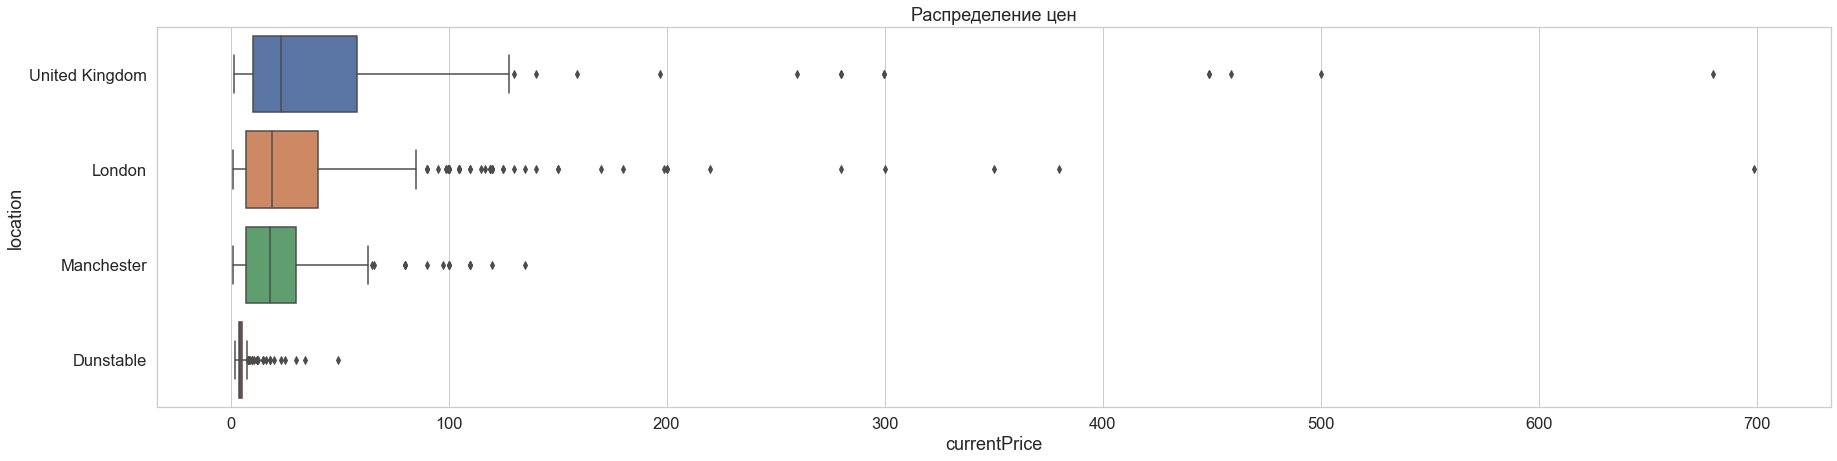

In [306]:
sns.boxplot(data = df_top_city , x = 'currentPrice', y = 'location')
plt.title('Распределение цен');

In [307]:
axis_labels = ['location', 'mean', 'median',  'mode', 'count']
df_top_city_stats = df_top_city.groupby('location').agg({'currentPrice' : ['mean', 'median', pd.Series.mode ,'count']}) \
    .reset_index().droplevel(level = 0, axis = 1)  \
    .set_axis(axis_labels, axis = 1) 

In [308]:
df_top_city_stats

,location,mean,median,mode,count
0,Dunstable,5.732176,4.50,3.95,216
1,London,35.191512,18.99,35.00,463
2,Manchester,23.533443,17.99,19.99,212
3,United Kingdom,48.280561,23.16,6.00,285


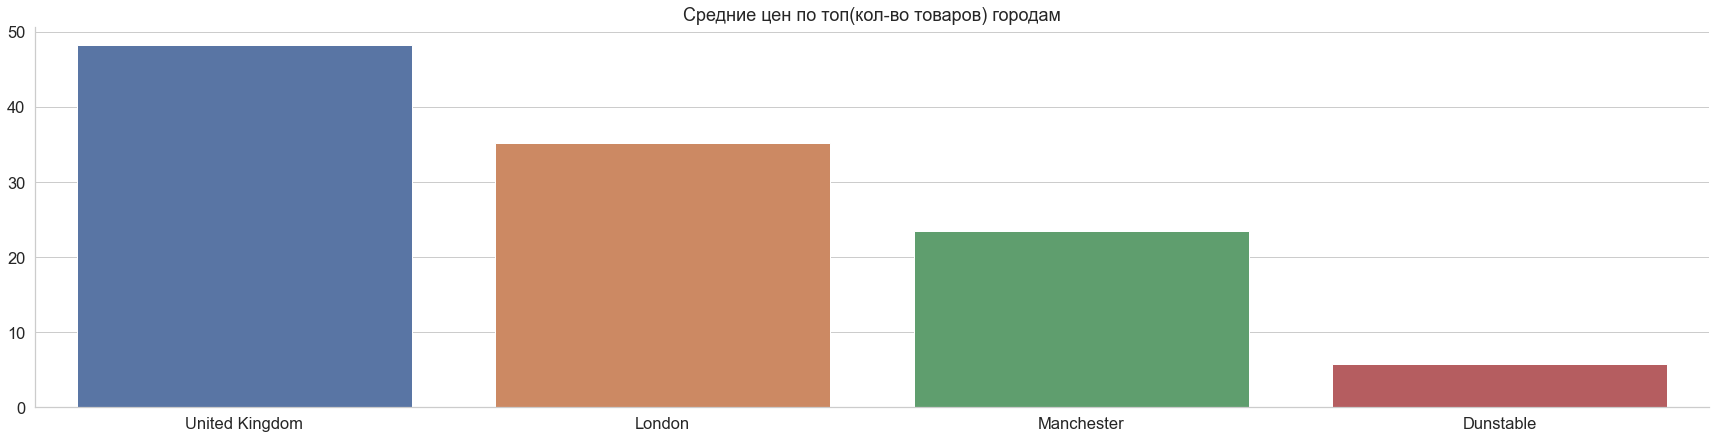

In [309]:
sns.barplot(data = df_top_city_stats, x = 'location', y = 'mean', \
            order = df_top_city_stats.sort_values('mean', ascending = False).location)
sns.despine()
plt.title('Средние цен по топ(кол-во товаров) городам')
plt.xlabel('')
plt.ylabel('')
plt.show()

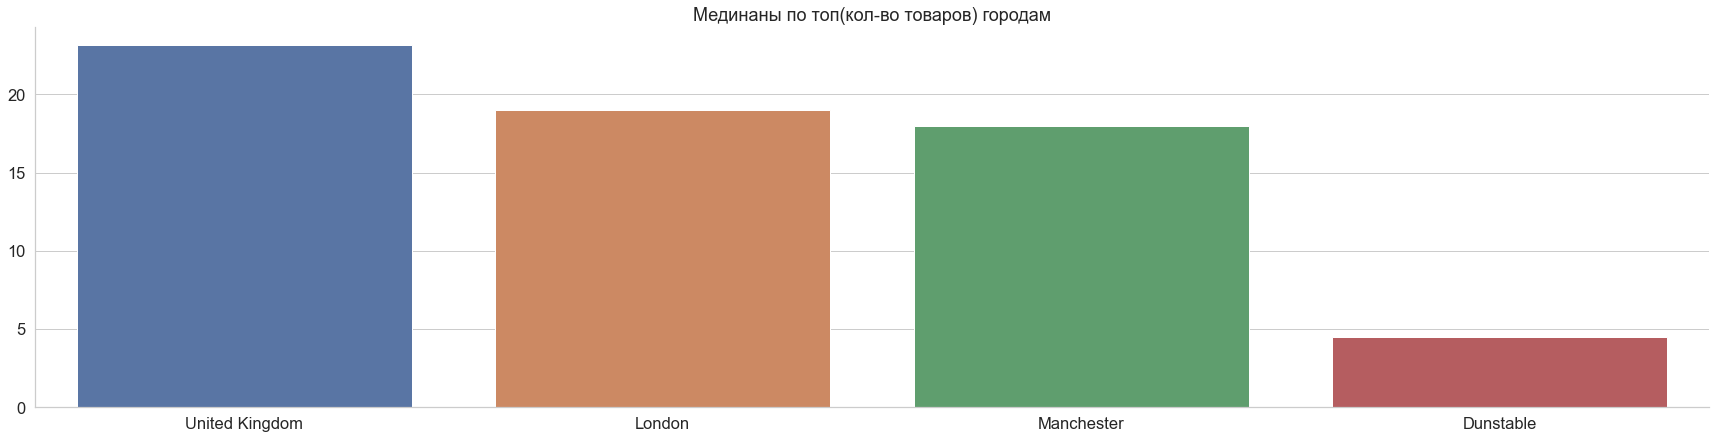

In [310]:
sns.barplot(data = df_top_city_stats, x = 'location', y = 'median', \
            order = df_top_city_stats.sort_values('median', ascending = False).location)
sns.despine()
plt.title('Мединаны по топ(кол-во товаров) городам')
plt.xlabel('')
plt.ylabel('')
plt.show()

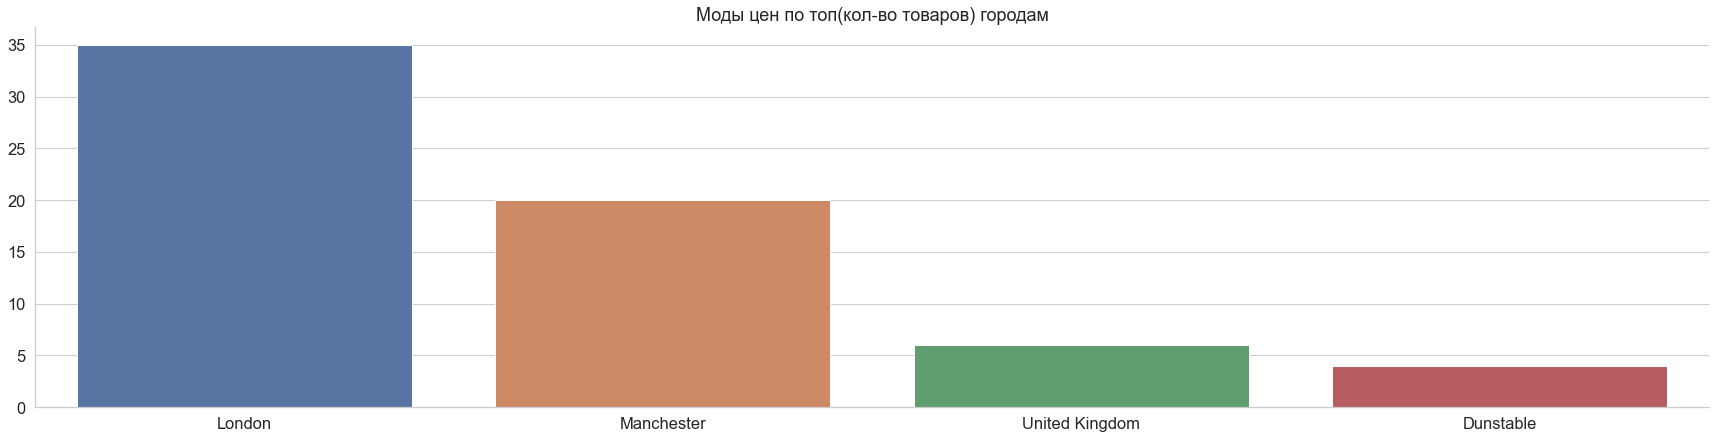

In [311]:
sns.barplot(data = df_top_city_stats, x = 'location', y = 'mode', \
            order = df_top_city_stats.sort_values('mode', ascending = False).location)
sns.despine()
plt.title('Моды цен по топ(кол-во товаров) городам')
plt.xlabel('')
plt.ylabel('')
plt.show()

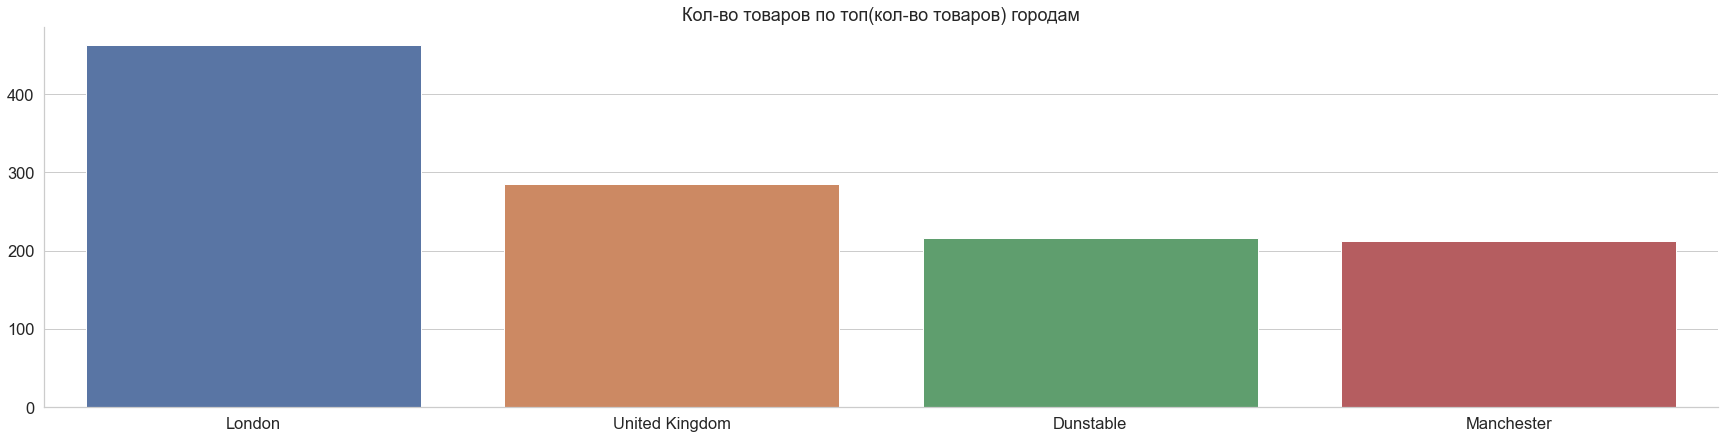

In [312]:
sns.barplot(data = df_top_city_stats, x = 'location', y = 'count', \
            order = df_top_city_stats.sort_values('count', ascending = False).location)
sns.despine()
plt.title('Кол-во товаров по топ(кол-во товаров) городам')
plt.xlabel('')
plt.ylabel('')
plt.show()

#### Вывод по городам
- Самые высокие значения по средней, моде и самому кол-ву товаров в Лондоне. Самые высокие значения медиан в неуказанных городах
- Для всех городов моды и средние приблизительно равны, кроме UK, что легко объяснимо: эта категория включает в себя разные города
- В Лондоне больше всего значений-выбросов
- В городе Данстэбл самые низкие цены, медиана, мода и среднее не сильно различаются.

### Различаются ли цены у топ объявлений и не топ объявлений?

Интересно посмотреть, есть ли различия в цене у таких объявлений. Для оценки я выберу **медиану цены** , так как не считаю, что в маркетплейсе целесообразно смотреть на средние цены: всё-таки выбросы велики, и это лишь единичные товары, которые не факт, что будут куплены.

Мода - слишком нестабльная статистика для проверки, к тому же цена - непрерывная величина.

In [313]:
df.topRatedListing.value_counts()

false    8575
true     1325
Name: topRatedListing, dtype: int64

Наблюдений достаточно, формирую выборки:

In [314]:
sample1 = df.query('topRatedListing == "true"').currentPrice
sample2 =  df.query('topRatedListing == "false"').currentPrice

Смотрю распределения на всякий случай:

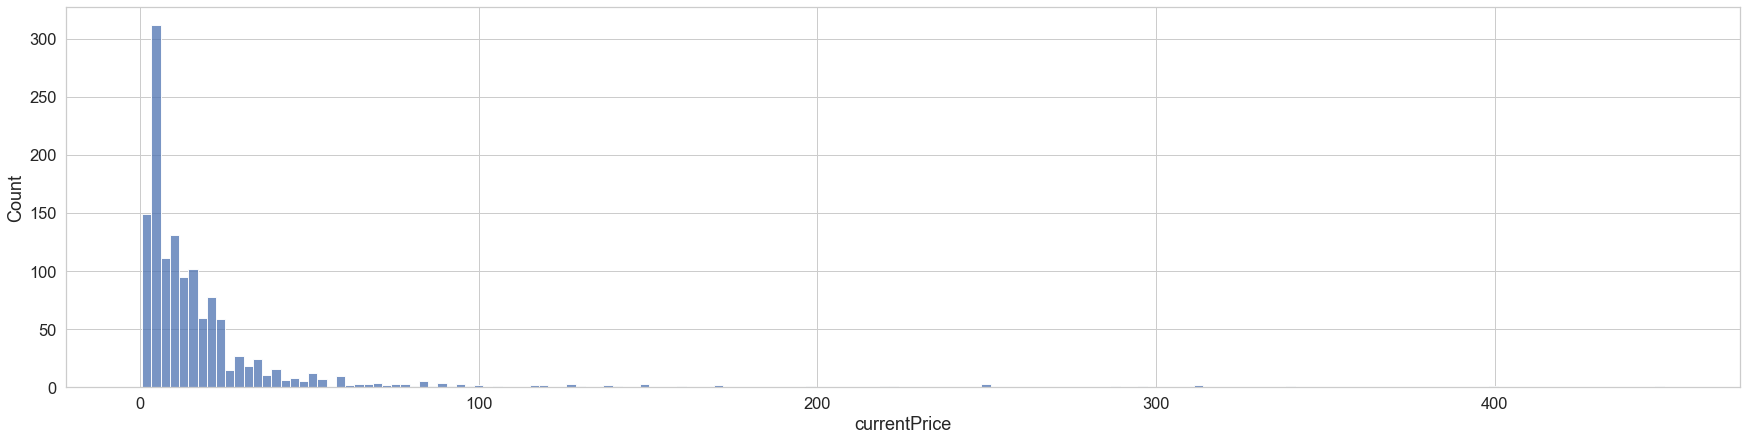

In [315]:
sns.histplot(sample1);

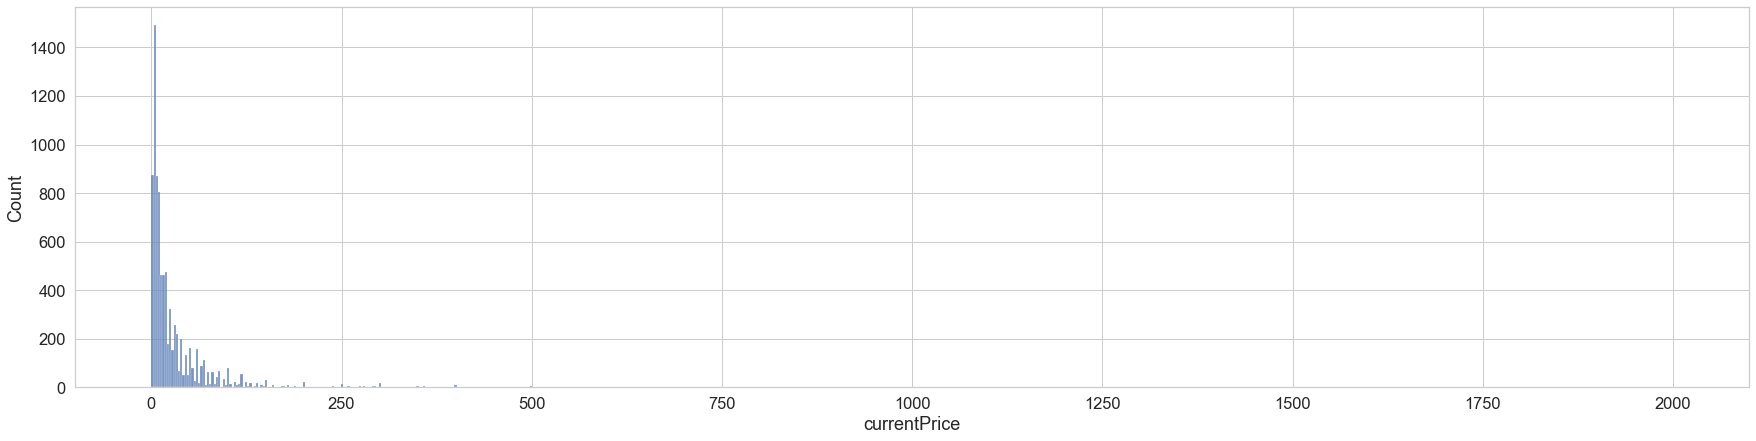

In [316]:
sns.histplot(sample2);

Применю **бутстрап** для оценки медианы и моды

In [317]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

#### Медиана

**H0:** медианы цен между топовыми объявлениями и не топовыми стат значимо не различаются

**H1:** медианы цен между топовыми объявлениями и не топовыми стат значимо различаются

  0%|          | 0/1000 [00:00<?, ?it/s]

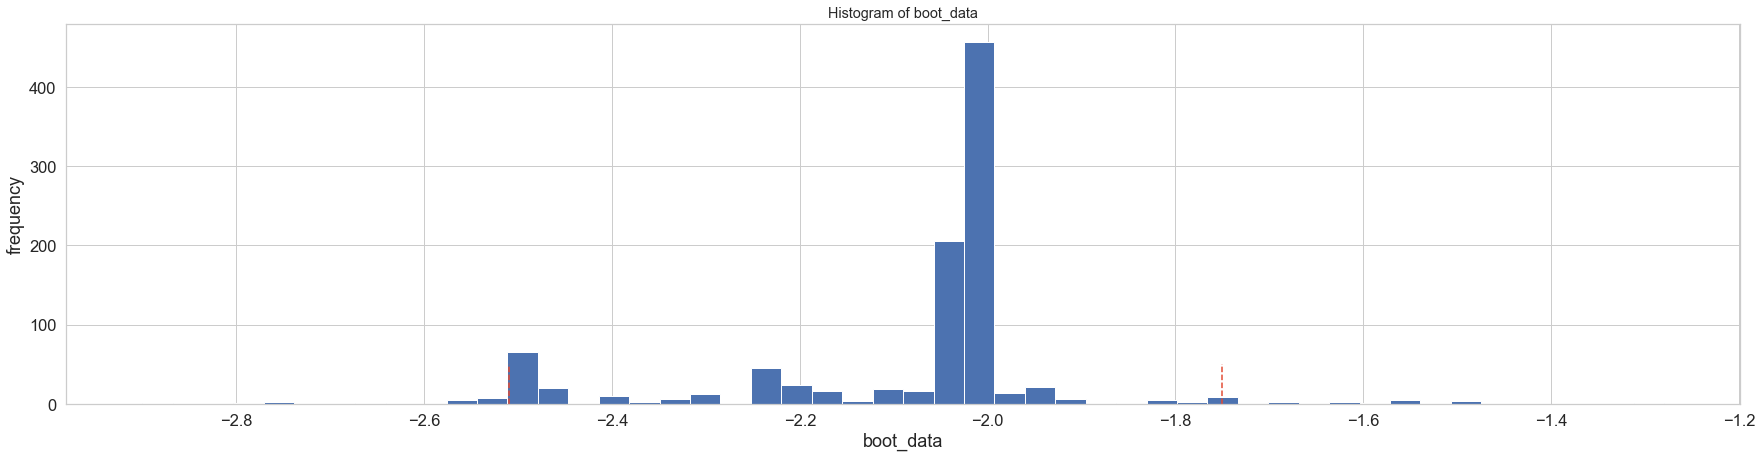

In [318]:
booted_data = get_bootstrap(sample1, sample2, statistic = np.median)

In [319]:
booted_data["p_value"]

3.636423614131712e-30

In [320]:
booted_data["ci"]

,0
0.025,-2.51
0.975,-1.75


**Вывод по бутстрапу для медианы цен**

0 не входит в интервал, отклоняем H1, **стат значимых различий между топовыми и не топовыми объявлениями нет**